In [245]:
import pandas as pd
import json 

In [246]:
data = pd.read_csv('storage/metrics_with_value.csv')

In [247]:
data

,idx,blk,expected_fee,actual_fee,carry,expected_price,actual_price,cex_price,pool_value
0,0,21763873,530,500,30,2495,2495,2483719500,303699.44
1,1,21763900,504,530,-26,2508,2508,2495300000,304511.77
2,2,21763956,521,500,21,2476,2476,2478756500,302514.10
3,3,21763988,504,521,-17,2488,2488,2482856667,303285.51
4,4,21764003,502,500,2,2480,2480,2489288500,302760.22
...,...,...,...,...,...,...,...,...,...
94,94,21765543,502,502,0,2607,2604,2605271000,509122.15
95,95,21765559,501,501,0,2601,2598,2597183333,508215.53
96,96,21765586,500,500,0,2601,2598,2602829333,508219.21
97,97,21765595,501,500,1,2602,2599,2599922000,508372.47


In [248]:
# We charged 348 more basis points than the normal fee structure over the 99 trades
# NOTE: EXPECTED_FEE IS WHAT WE ACTUALLY CHARGED!!!
# ACTUAL FEE is what we calculate in the post swap hook
total_fees_charged_with_hook = data["expected_fee"].sum()
total_fees_charged_without_hook = len(data)*500
print(f"total_fees_charged_with_hook: {total_fees_charged_with_hook}")
print(f"total_fees_charged_without_hook: {total_fees_charged_without_hook}")
print(f"difference: {total_fees_charged_with_hook - total_fees_charged_without_hook}")

total_fees_charged_with_hook: 49848
total_fees_charged_without_hook: 49500
difference: 348


In [249]:
# Load in the actual swap data to get the actual trade amounts
file_path = "swaps-v4.json"
with open(file_path, 'r') as f:
    swap_data = json.load(f)

print(swap_data)
print(len(swap_data['data']['pool']['swaps'][1:]))
swaps = swap_data['data']['pool']['swaps'][1:]
amounts = [float(swap['amount0']) for swap in swaps]

{'data': {'pool': {'id': '0x21c67e77068de97969ba93d4aab21826d33ca12bb9f565d8496e8fda8a82ca27', 'swaps': [{'amount0': '0.01', 'amount1': '-24.570258', 'sqrtPriceX96': '3927370225299858350344231', 'tick': '-198253', 'transaction': {'blockNumber': '21763860', 'timestamp': '1738560095'}}, {'amount0': '-0.18164518378060225', 'amount1': '450', 'sqrtPriceX96': '3957571311565728313725595', 'tick': '-198100', 'transaction': {'blockNumber': '21763873', 'timestamp': '1738560251'}}, {'amount0': '-0.159720711913529738', 'amount1': '400', 'sqrtPriceX96': '3967868019507835531521729', 'tick': '-198048', 'transaction': {'blockNumber': '21763900', 'timestamp': '1738560575'}}, {'amount0': '0.25', 'amount1': '-623.894044', 'sqrtPriceX96': '3942524046462522475894499', 'tick': '-198176', 'transaction': {'blockNumber': '21763956', 'timestamp': '1738561247'}}, {'amount0': '-0.058773870426287785', 'amount1': '145.971764', 'sqrtPriceX96': '3952320726092255143926839', 'tick': '-198126', 'transaction': {'blockNum

In [250]:
data['eth_trade_amount'] = amounts

In [251]:
# Calculate (pi-qi) where pi is the CEX price and qi is the AMM price
data['CEX_Price_sub_AMM_Price'] = data['cex_price']/1e6 - data['actual_price']
data['fees_charged_no_hook'] = 500
data.head()

,idx,blk,expected_fee,actual_fee,carry,expected_price,actual_price,cex_price,pool_value,eth_trade_amount,CEX_Price_sub_AMM_Price,fees_charged_no_hook
0,0,21763873,530,500,30,2495,2495,2483719500,303699.44,-0.181645,-11.280500,500
1,1,21763900,504,530,-26,2508,2508,2495300000,304511.77,-0.159721,-12.700000,500
2,2,21763956,521,500,21,2476,2476,2478756500,302514.10,0.250000,2.756500,500
3,3,21763988,504,521,-17,2488,2488,2482856667,303285.51,-0.058774,-5.143333,500
4,4,21764003,502,500,2,2480,2480,2489288500,302760.22,0.040000,9.288500,500


In [252]:
# Calculate LVR_Normalized for each trade(Multiply by -1 since the eth_trade_amount is negative if the AMM is selling eth)
data['LVR_Normalized'] = (-1*data['eth_trade_amount']*data['CEX_Price_sub_AMM_Price'])/data['pool_value']
data['LVR_Normalized'] = data['LVR_Normalized'] * 1e6 # This converts to basis points

In [253]:
positive_lvr_trades = data[data['LVR_Normalized'] > 0].head()
positive_lvr_trades.head()

,idx,blk,expected_fee,actual_fee,carry,expected_price,actual_price,cex_price,pool_value,eth_trade_amount,CEX_Price_sub_AMM_Price,fees_charged_no_hook,LVR_Normalized
5,5,21764042,501,502,-1,2481,2481,2511061333,302865.90,-0.008057,30.061333,500,0.799732
6,6,21764057,501,500,1,2488,2488,2503143500,303285.18,-0.031898,15.143500,500,1.592724
8,8,21764087,527,500,27,2494,2494,2498377333,352003.92,-0.739716,4.377333,500,9.198712
10,10,21764135,501,500,1,2500,2500,2507431333,352415.06,-0.019993,7.431333,500,0.421589
12,12,21764156,501,500,1,2496,2496,2518829500,352190.57,-0.055138,22.829500,500,3.574098


In [254]:
extra_fees_charged_cum_sum = (data['expected_fee'] - 500).cumsum()

Total Extra Fees Charged: 348


<Axes: >

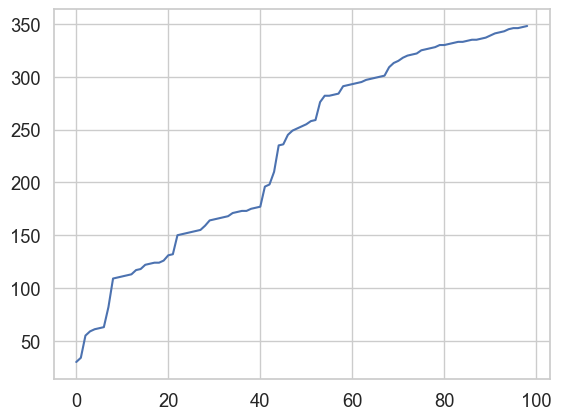

In [255]:
print(f"Total Extra Fees Charged: {extra_fees_charged_cum_sum.iloc[-1]}")
extra_fees_charged_cum_sum.plot()


In [256]:
data['LVR_Norm_positive_or_zero'] = data['LVR_Normalized'].where(data['LVR_Normalized'] > 0, 0)
data['LVR_Norm_absolute_value'] = data['LVR_Normalized'].abs()

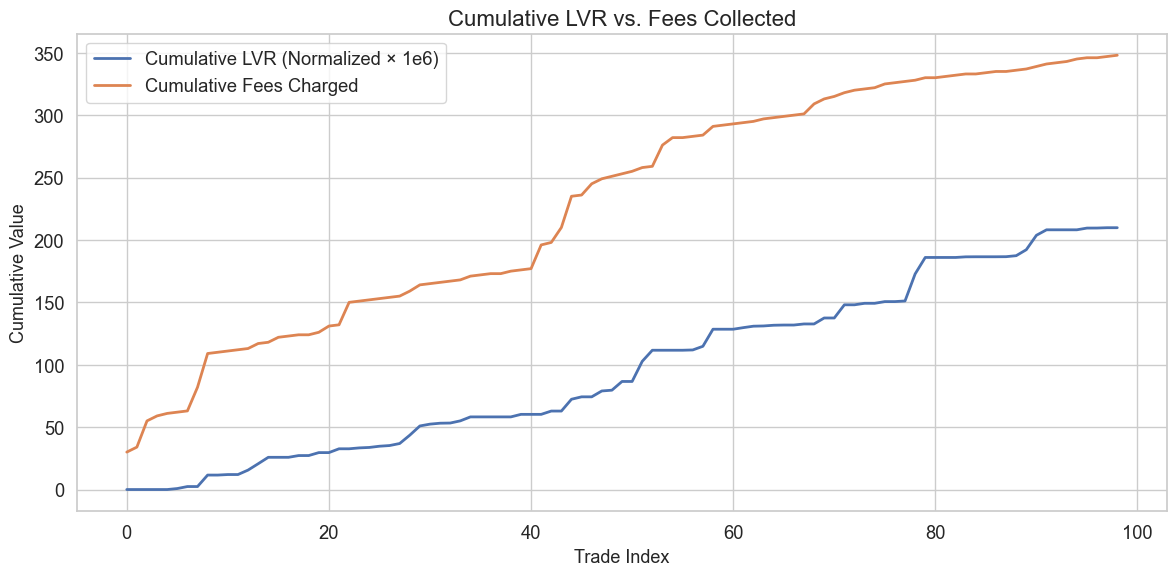

In [261]:

# This is the the plot of the cumulative LVR vs. the cumulative fees charged (FOR JUST THE POSITIVE LVR TRADES)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: use a nice seaborn theme
sns.set(style="whitegrid", font_scale=1.2)

# Prepare data
lvr_cumsum = (data['LVR_Norm_positive_or_zero']).cumsum()
fees_cumsum = (data['expected_fee'] - 500).cumsum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(lvr_cumsum, label='Cumulative LVR (Normalized × 1e6)', linewidth=2)
plt.plot(fees_cumsum, label='Cumulative Fees Charged', linewidth=2)

# Add labels and title
plt.title("Cumulative LVR vs. Fees Collected", fontsize=16)
plt.xlabel("Trade Index", fontsize=13)
plt.ylabel("Cumulative Value", fontsize=13)

# Add legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


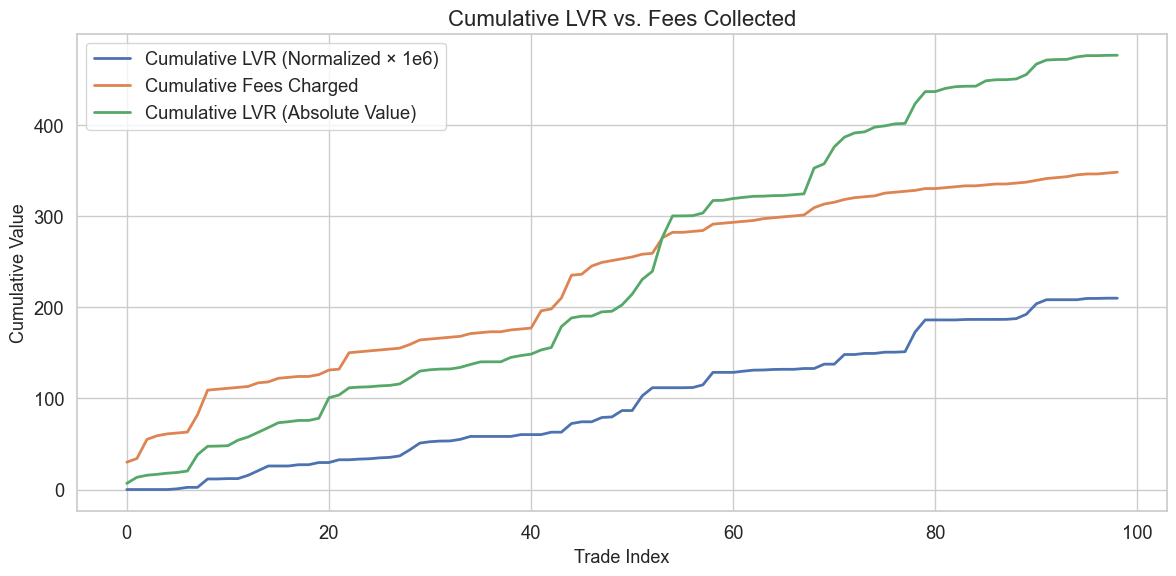

In [262]:

# This is the the plot of the cumulative LVR vs. the cumulative fees charged (FOR JUST THE POSITIVE LVR TRADES)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: use a nice seaborn theme
sns.set(style="whitegrid", font_scale=1.2)

# Prepare data
lvr_cumsum = (data['LVR_Norm_positive_or_zero']).cumsum()
lvr_abs_value_cumsum = (data['LVR_Norm_absolute_value']).cumsum()
fees_cumsum = (data['expected_fee'] - 500).cumsum()


# Plot
plt.figure(figsize=(12, 6))
plt.plot(lvr_cumsum, label='Cumulative LVR (Normalized × 1e6)', linewidth=2)
plt.plot(fees_cumsum, label='Cumulative Fees Charged', linewidth=2)
plt.plot(lvr_abs_value_cumsum, label='Cumulative LVR (Absolute Value)', linewidth=2)

# Add labels and title
plt.title("Cumulative LVR vs. Fees Collected", fontsize=16)
plt.xlabel("Trade Index", fontsize=13)
plt.ylabel("Cumulative Value", fontsize=13)

# Add legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
data[data['LVR'] > 0]['LVR_Normalized'].sum() * 1e6

209.8032557359983

In [199]:
data["LVR_Norm_abs_value"] = data['LVR_Normalized'].abs()

<Axes: >

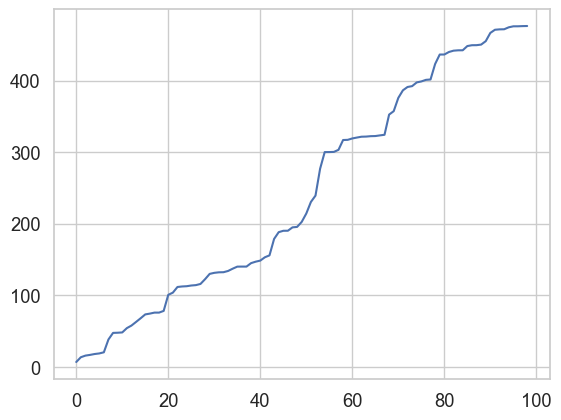

In [202]:
(data["LVR_Norm_abs_value"].cumsum()* 1e6).plot() 